### Filtering for both *tridentata* and *vaseyana* diploids

Uses ARTR_chr.biallelic.vcf.gz to start

Sample names have been extracted to subset using:   
- zcat ARTR_chr.vcf.gz | bcftools query -l | sort > sample_index.txt

In [1]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [2]:
vcfutils = "vcfutils.pl"
vcftools = "vcftools"
bcftools = "bcftools"
bgzip = "bgzip"
tabix = "tabix"
java = "java"
plink = "plink --noweb"

In [3]:
analysis_dir = "/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering"

In [4]:
cd $analysis_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering


In [5]:
vcf_file = os.path.join(analysis_dir, "ARTR_chr.biallelic.recode.vcf.gz")
assert os.path.exists(vcf_file)
vcf_file

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/ARTR_chr.biallelic.recode.vcf.gz'

### keep only AV2 individuals

In [6]:
sample_names = pd.read_csv('sample_index.txt',header=None,names=['sample'])
sample_names.head()

,sample
0,AT2_BB_1
1,AT2_BB_10
2,AT2_BB_11
3,AT2_BB_12
4,AT2_BB_13


In [12]:
AV2_indv = [s for s in sample_names['sample'] if 'AV2' in s]
AT2_indv = [s for s in sample_names['sample'] if 'AT2' in s]
ATAV2_indv = AT2_indv + AV2_indv

In [18]:
len(ATAV2_indv), ATAV2_indv[0]

(407, 'AT2_BB_1')

In [19]:
with open(os.path.join(analysis_dir, "ATAV2_indv.txt"), "w") as o:
    o.write("INDV\n")
    for elem in ATAV2_indv:
        o.write("%s\n" % elem)

In [20]:
!$vcftools --gzvcf $vcf_file \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--keep {os.path.join(analysis_dir, "ATAV2_indv.txt")} \
--out {os.path.join(analysis_dir, "ATAV2_chr.biallelic")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/ARTR_chr.biallelic.recode.vcf.gz
	--keep /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/ATAV2_indv.txt
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/ATAV2_chr.biallelic
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
Keeping individuals in 'keep' list
After filtering, kept 407 out of 708 Individuals
Outputting VCF file...
After filtering, kept 2766918 out of a possible 2766918 Sites
Run Time = 2413.00 seconds


In [22]:
vcf_ATAV2 = "ATAV2_chr.biallelic.recode.vcf" 
vcf_ATAV2_gz = "%s.gz" % vcf_ATAV2
!$bgzip -c $vcf_ATAV2 > {vcf_ATAV2_gz}
!$tabix {vcf_ATAV2_gz}

## Remove by MAF, missing, and thin next

In [23]:
!$vcftools \
--maf 0.01 \
--thin 100 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_ATAV2_gz \
--out $'ATAV2_chr_thin100_MAF1'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ATAV2_chr.biallelic.recode.vcf.gz
	--recode-INFO-all
	--maf 0.01
	--thin 100
	--out ATAV2_chr_thin100_MAF1
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 407 out of 407 Individuals
Outputting VCF file...
After filtering, kept 467724 out of a possible 2766918 Sites
Run Time = 501.00 seconds


In [24]:
vcf_filtered = "ATAV2_chr_thin100_MAF1.recode.vcf"
vcf_filtered_gz = "%s.gz" % vcf_filtered

In [25]:
!$bgzip -c $vcf_filtered > {vcf_filtered_gz}
!$tabix {vcf_filtered_gz}

# Calulate missing data and private alleles using vcfR


In [26]:
%load_ext rpy2.ipython

In [28]:
%%R
require(readr)
library(data.table)
require(MASS)
require(ggplot2)
library(vcfR)

source('/data/gpfs/home/tfaske/g/src/R/Imports.R')

setwd('/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/')

In [29]:
%%R
vcf <- read.vcfR("ATAV2_chr_thin100_MAF1.recode.vcf", verbose = FALSE)

#get positions
chrom <- getCHROM(vcf)
pos <- getPOS(vcf)
pos_ID <- paste(chrom,pos,sep = ':')

In [30]:
%%R
#get pl 
dp <- extract.gt(vcf, element = 'DP')

In [31]:
%%R
## check out PL and pos_ID
print(length(pos_ID))
print(pos_ID[1:10])
dp[1:5,1:5]

[1] 467724
 [1] "CM042338.1:22493"  "CM042338.1:59115"  "CM042338.1:97078" 
 [4] "CM042338.1:106063" "CM042338.1:126072" "CM042338.1:128439"
 [7] "CM042338.1:129199" "CM042338.1:129763" "CM042338.1:130233"
[10] "CM042338.1:169173"
                  AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14
CM042338.1_22493  "0"       "0"       "0"       "0"       "0"      
CM042338.1_59115  "3"       "0"       "0"       "0"       "0"      
CM042338.1_97078  "0"       "0"       "0"       "0"       "0"      
CM042338.1_106063 "0"       "0"       "0"       "0"       "0"      
CM042338.1_126072 "2"       "0"       "2"       "1"       "4"      


In [32]:
%%R
str(dp[1:5,1:5])

 chr [1:5, 1:5] "0" "3" "0" "0" "2" "0" "0" "0" "0" "0" "0" "0" "0" "0" "2" ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:5] "CM042338.1_22493" "CM042338.1_59115" "CM042338.1_97078" "CM042338.1_106063" ...
  ..$ : chr [1:5] "AT2_BB_10" "AT2_BB_11" "AT2_BB_12" "AT2_BB_13" ...


#### Calculate missing loci and individual

In [35]:
%%R
nindv <- ncol(dp)
nloci <- nrow(dp)
print(nloci)
print(nindv)

[1] 467724
[1] 407


In [36]:
%%R
miss_loci <- apply(dp,1, function(d) length(which(d == "0"))/nindv)
#miss_loci <- apply(dp[,1:100],1, function(d) (length(which(d == "0"))/100))
print(summary(miss_loci))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.9853  0.9975  0.9130  1.0000  1.0000 


In [37]:
%%R
print(length(which(miss_loci <= .30)))
print(length(which(miss_loci <= .40)))
print(length(which(miss_loci <= .50)))
print(length(which(miss_loci <= .60)))
print(length(which(miss_loci <= .70)))

[1] 13538
[1] 21897
[1] 31934
[1] 44112
[1] 58279


In [38]:
%%R
keep_miss <- pos_ID[which(miss_loci <= .60)]
length(keep_miss)

[1] 44112


In [39]:
%%R
keep_miss60_df <- data.frame(chrom=sapply(keep_miss,function(s) unlist(strsplit(as.character(s),':'))[1]),
                             pos=sapply(keep_miss,function(s) unlist(strsplit(as.character(s),':'))[2]))
print(head(keep_miss60_df))    
write.table(keep_miss60_df,'keep_miss60.txt',quote=F,row.names=F,col.names=F,sep='\t')

                        chrom     pos
CM042338.1:126072  CM042338.1  126072
CM042338.1:1342981 CM042338.1 1342981
CM042338.1:1496841 CM042338.1 1496841
CM042338.1:1744222 CM042338.1 1744222
CM042338.1:1942811 CM042338.1 1942811
CM042338.1:2385838 CM042338.1 2385838


In [40]:
!head keep_miss60.txt

CM042338.1	126072
CM042338.1	1342981
CM042338.1	1496841
CM042338.1	1744222
CM042338.1	1942811
CM042338.1	2385838
CM042338.1	4255378
CM042338.1	6087026
CM042338.1	6353755
CM042338.1	7629194


In [41]:
!$vcftools --vcf {"ATAV2_chr_thin100_MAF1.recode.vcf"} \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--positions {os.path.join(analysis_dir, "keep_miss60.txt")} \
--out {os.path.join(analysis_dir, "ATAV2_chr_miss60_thin100_MAF1")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ATAV2_chr_thin100_MAF1.recode.vcf
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/ATAV2_chr_miss60_thin100_MAF1
	--positions /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/keep_miss60.txt
	--recode
	--remove-filtered-all

After filtering, kept 407 out of 407 Individuals
Outputting VCF file...
After filtering, kept 44112 out of a possible 467724 Sites
Run Time = 40.00 seconds


In [42]:
vcf_filtered = "ATAV2_chr_miss60_thin100_MAF1.recode.vcf"
vcf_filtered_gz = "%s.gz" % vcf_filtered
!$bgzip -c $vcf_filtered > {vcf_filtered_gz}
!$tabix {vcf_filtered_gz}

# Remove bad_indv

by do it by mean_depth cause no missing data 

In [43]:
!$vcftools --gzvcf {vcf_filtered_gz} \
--out {vcf_filtered_gz} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ATAV2_chr_miss60_thin100_MAF1.recode.vcf.gz
	--depth
	--out ATAV2_chr_miss60_thin100_MAF1.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 407 out of 407 Individuals
Outputting Mean Depth by Individual
After filtering, kept 44112 out of a possible 44112 Sites
Run Time = 3.00 seconds


In [44]:
depth_file = vcf_filtered_gz + ".idepth"
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,AT2_BB_10,44112,2.79357
1,AT2_BB_11,44112,1.83329
2,AT2_BB_12,44112,1.56740
3,AT2_BB_13,44112,2.30971
4,AT2_BB_14,44112,3.22552


In [45]:
depth_df.MEAN_DEPTH.describe()

count    407.000000
mean       1.834896
std        0.625635
min        0.004693
25%        1.414330
50%        1.784710
75%        2.233930
max        3.936960
Name: MEAN_DEPTH, dtype: float64

In [46]:
len(depth_df),len(depth_df[depth_df.MEAN_DEPTH <= .05]),len(depth_df[depth_df.MEAN_DEPTH <= .1]), len(depth_df[depth_df.MEAN_DEPTH <= .15])


(407, 4, 4, 4)

In [47]:
bad_indv = depth_df.INDV[depth_df.MEAN_DEPTH <= .1]

In [48]:
with open(os.path.join(analysis_dir, "bad_indv.txt"), "w") as o:
    o.write("INDV\n")
    for elem in bad_indv:
        o.write("%s\n" % elem)

In [49]:
!cat bad_indv.txt

INDV
AT2_LN_97
AT2_OC_1
AT2_SS_9
AV2_TF_149


In [50]:
!$vcftools --gzvcf $vcf_filtered_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--remove {os.path.join(analysis_dir, "bad_indv.txt")} \
--out {os.path.join(analysis_dir, "snps_indv_removed")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ATAV2_chr_miss60_thin100_MAF1.recode.vcf.gz
	--remove /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/bad_indv.txt
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/snps_indv_removed
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
Excluding individuals in 'exclude' list
After filtering, kept 403 out of 407 Individuals
Outputting VCF file...
After filtering, kept 44112 out of a possible 44112 Sites
Run Time = 35.00 seconds


In [51]:
vcf_bad_remove = os.path.join(analysis_dir, "snps_indv_removed.recode.vcf")
vcf_bad_remove_gz = vcf_bad_remove + ".gz"
!$bgzip -c {vcf_bad_remove} > {vcf_bad_remove_gz}
!$tabix {vcf_bad_remove_gz}

# Filter snps further 
this needs to be done after removing individuals


In [52]:
def get_vcf_stats(vcf_gz):
    
    stats = ['depth',
            'site-depth',
            'site-mean-depth',
            'site-quality',
            'missing-site',
            'freq',
            'counts',
            'hardy',
            'het']
    
    for stat in stats:
        !$vcftools --gzvcf $vcf_gz \
        --out $vcf_gz \
        {"--%s" % stat} 

In [53]:
get_vcf_stats(vcf_bad_remove_gz)


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/snps_indv_removed.recode.vcf.gz
	--depth
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 403 out of 403 Individuals
Outputting Mean Depth by Individual
After filtering, kept 44112 out of a possible 44112 Sites
Run Time = 3.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/snps_indv_removed.recode.vcf.gz
	--site-depth

Using zlib version: 1.2.11
After filtering, kept 403 out of 403 Individuals
Outputting Depth for Each Site
After filtering, kept 44112 out of a possible 44112 Sites
Run Time = 4.00 se

After filtering, kept 44112 out of a possible 44112 Sites
Run Time = 3.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/snps_indv_removed.recode.vcf.gz
	--hardy
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 403 out of 403 Individuals
Outputting HWE statistics (but only for biallelic loci)
After filtering, kept 44112 out of a possible 44112 Sites
Run Time = 4.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/snps_indv_removed.recode.vcf.gz
	--het
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 403 out of 403 Individuals
Outputting I

In [54]:
#pd.set_option('display.max_columns', 100)

def get_MAF(row):
    try:
        return np.min([row.A1_freq, row.A2_freq])
    except:
        print(row)
        
def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def calculate_Fis(vals):
    try:
        data = [float(x) for x in vals.split("/")]
        assert len(data) == 3
        num_individuals = np.sum(data)
        total_alleles = 2*num_individuals
        a1_count = 2*data[0]
        a2_count = 2*data[2]
        het_count = data[1]
        a1_count += het_count
        a2_count += het_count
        a1_freq = a1_count/total_alleles
        a2_freq = a2_count/total_alleles
        assert a1_freq + a2_freq == 1.0
        He = 2 * a1_freq * a2_freq * get_correction(num_individuals)
        Ho = het_count/num_individuals
        Fis = 1 - (Ho/He)
        return Fis
    except:
        return -9

def combine_vcf_stats(filedir, prefix):
    
    hardy_files = !ls {filedir}/{prefix}.hwe
    hardy = pd.read_csv(hardy_files[0], sep="\t")

    hardy.columns = ['CHROM', 'POS', 'OBS(HOM1/HET/HOM2)', 'E(HOM1/HET/HOM2)', 'ChiSq_HWE',
       'P_HWE', 'P_HET_DEFICIT', 'P_HET_EXCESS']
    hardy.index = hardy.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_files = !ls {filedir}/{prefix}.l* | grep -v log
    loci_df = pd.concat([pd.read_csv(x, sep="\t", skiprows=0) for x in loci_files], axis=1)
    chrom_pos = loci_df.ix[:,0:2]
    
    frq_files = !ls {filedir}/{prefix}.frq* | grep -v count
    frq_data = []
    h = open(frq_files[0])
    header = h.readline().strip().split()
    for line in h:
        frq_data.append(line.strip().split('\t'))

    header = ['CHROM', 'POS', 'N_ALLELES', 'N_CHR', 'A1_FREQ', "A2_FREQ"]
    frq_df = pd.DataFrame(frq_data)
    print(frq_df.columns)
    #frq_df = frq_df.drop([6,7],axis=1)
    frq_df.columns = header
    frq_df.index = frq_df.apply(lambda x: "%s-%s" % (x.CHROM, x.POS), axis=1)
    
    loci_df = loci_df.drop(['CHROM','CHR','POS'], axis=1)
    loci_df = pd.concat([chrom_pos, loci_df], axis=1)
    loci_df.index = loci_df.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_df = pd.concat([loci_df, frq_df, hardy], axis=1)
    loci_df["A1_allele"] = loci_df.apply(lambda row: row.A1_FREQ.split(":")[0], axis=1)
    loci_df["A2_allele"] = loci_df.apply(lambda row: row.A2_FREQ.split(":")[0], axis=1)
    
    loci_df["A1_freq"] = loci_df.apply(lambda row: float(row.A1_FREQ.split(":")[1]), axis=1)
    loci_df["A2_freq"] = loci_df.apply(lambda row: float(row.A2_FREQ.split(":")[1]), axis=1)
    
    loci_df['MAF'] = loci_df.apply(get_MAF, axis=1)
    loci_df = loci_df.drop(['CHROM', 'POS'], axis=1)
    
    loci_df['Fis'] = loci_df['OBS(HOM1/HET/HOM2)'].apply(calculate_Fis)
    
    return loci_df, frq_df, hardy

In [55]:
vcf_bad_remove_gz

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/snps_indv_removed.recode.vcf.gz'

In [56]:
loci_df, frq_df, hardy = combine_vcf_stats(analysis_dir,'snps_indv_removed.recode.vcf.gz')

/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


RangeIndex(start=0, stop=6, step=1)


In [57]:
loci_df

,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS,QUAL,N_ALLELES,...,ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS,A1_allele,A2_allele,A1_freq,A2_freq,MAF,Fis
CM042338.1-126072,325,869,0.806452,1.50971,806,0,0,0,999.0,2,...,53.073740,2.518773e-08,2.518773e-08,1.000000,C,G,0.921836,0.078164,0.078164,0.363691
CM042338.1-1342981,629,2831,1.560790,4.60015,806,0,0,0,999.0,2,...,5.041315,4.298719e-02,3.018760e-02,0.990461,G,A,0.900744,0.099256,0.099256,0.112948
CM042338.1-1496841,1040,6738,2.580650,10.08490,806,0,0,0,999.0,2,...,0.063603,1.000000e+00,1.000000e+00,0.945068,G,C,0.987593,0.012407,0.012407,-0.011307
CM042338.1-1744222,667,3403,1.655090,5.71905,806,0,0,0,999.0,2,...,0.108304,1.000000e+00,1.000000e+00,0.906375,A,T,0.983871,0.016129,0.016129,-0.015132
CM042338.1-1942811,614,3804,1.523570,7.13564,806,0,0,0,999.0,2,...,0.000062,1.000000e+00,6.387059e-01,0.748395,G,A,0.950372,0.049628,0.049628,0.001632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CM042346.1-338104939,746,2732,1.851120,3.36086,806,0,0,0,999.0,2,...,0.051389,1.000000e+00,1.000000e+00,0.955862,C,A,0.988834,0.011166,0.011166,-0.010038
CM042346.1-338202655,721,2553,1.789080,3.14197,806,0,0,0,999.0,2,...,0.092051,1.000000e+00,1.000000e+00,0.920283,T,G,0.985112,0.014888,0.014888,-0.013854
CM042346.1-338204096,675,3421,1.674940,5.69755,806,0,0,0,999.0,2,...,0.077154,1.000000e+00,1.000000e+00,0.933195,G,C,0.986352,0.013648,0.013648,-0.012579
CM042346.1-338208546,1137,5783,2.821340,6.40581,806,0,0,0,999.0,2,...,0.051389,1.000000e+00,1.000000e+00,0.955862,G,A,0.988834,0.011166,0.011166,-0.010038


In [58]:
frq_df

,CHROM,POS,N_ALLELES,N_CHR,A1_FREQ,A2_FREQ
CM042338.1-126072,CM042338.1,126072,2,806,C:0.921836,G:0.0781638
CM042338.1-1342981,CM042338.1,1342981,2,806,G:0.900744,A:0.0992556
CM042338.1-1496841,CM042338.1,1496841,2,806,G:0.987593,C:0.0124069
CM042338.1-1744222,CM042338.1,1744222,2,806,A:0.983871,T:0.016129
CM042338.1-1942811,CM042338.1,1942811,2,806,G:0.950372,A:0.0496278
...,...,...,...,...,...,...
CM042346.1-338104939,CM042346.1,338104939,2,806,C:0.988834,A:0.0111663
CM042346.1-338202655,CM042346.1,338202655,2,806,T:0.985112,G:0.0148883
CM042346.1-338204096,CM042346.1,338204096,2,806,G:0.986352,C:0.0136476
CM042346.1-338208546,CM042346.1,338208546,2,806,G:0.988834,A:0.0111663


In [59]:
hardy

,CHROM,POS,OBS(HOM1/HET/HOM2),E(HOM1/HET/HOM2),ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS
CM042338.1-126072,CM042338.1,126072,353/37/13,342.46/58.08/2.46,53.073740,2.518773e-08,2.518773e-08,1.000000
CM042338.1-1342981,CM042338.1,1342981,331/64/8,326.97/72.06/3.97,5.041315,4.298719e-02,3.018760e-02,0.990461
CM042338.1-1496841,CM042338.1,1496841,393/10/0,393.06/9.88/0.06,0.063603,1.000000e+00,1.000000e+00,0.945068
CM042338.1-1744222,CM042338.1,1744222,390/13/0,390.10/12.79/0.10,0.108304,1.000000e+00,1.000000e+00,0.906375
CM042338.1-1942811,CM042338.1,1942811,364/38/1,363.99/38.01/0.99,0.000062,1.000000e+00,6.387059e-01,0.748395
...,...,...,...,...,...,...,...,...
CM042346.1-338104939,CM042346.1,338104939,394/9/0,394.05/8.90/0.05,0.051389,1.000000e+00,1.000000e+00,0.955862
CM042346.1-338202655,CM042346.1,338202655,391/12/0,391.09/11.82/0.09,0.092051,1.000000e+00,1.000000e+00,0.920283
CM042346.1-338204096,CM042346.1,338204096,392/11/0,392.08/10.85/0.08,0.077154,1.000000e+00,1.000000e+00,0.933195
CM042346.1-338208546,CM042346.1,338208546,394/9/0,394.05/8.90/0.05,0.051389,1.000000e+00,1.000000e+00,0.955862


In [60]:
loci_out = os.path.join(analysis_dir,'loci_out.csv')
frq_out = os.path.join(analysis_dir,'frq_out.csv')
hardy_out = os.path.join(analysis_dir,'hardy_out.csv')

loci_df.to_csv(path_or_buf=loci_out)
frq_df.to_csv(path_or_buf=frq_out)
hardy.to_csv(path_or_buf=hardy_out)


In [61]:
loci_df.SUM_DEPTH.describe()

count    44112.000000
mean       746.701714
std       1000.961129
min        231.000000
25%        437.000000
50%        601.000000
75%        874.000000
max      93204.000000
Name: SUM_DEPTH, dtype: float64

In [62]:
loci_df.MEAN_DEPTH.describe()

count    44112.000000
mean         1.852858
std          2.483773
min          0.573201
25%          1.084370
50%          1.491320
75%          2.168730
max        231.275000
Name: MEAN_DEPTH, dtype: float64

In [63]:
loci_df.QUAL.describe()

count    44112.000000
mean       990.743075
std         85.721033
min          3.935900
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: QUAL, dtype: float64

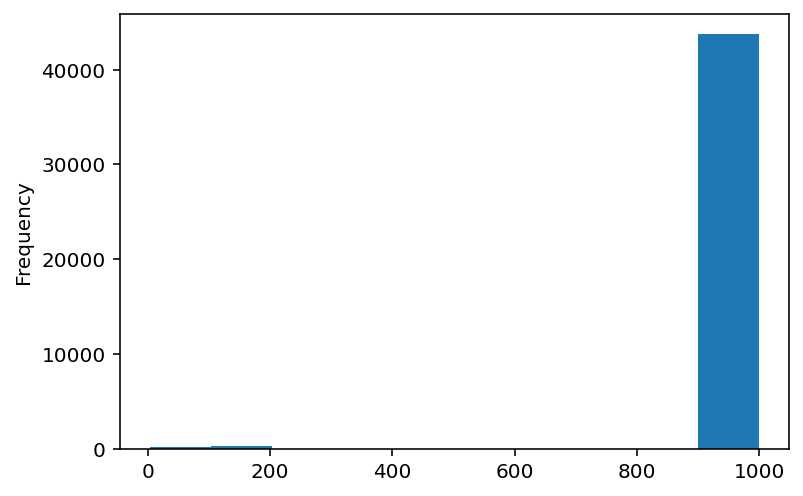

In [64]:
loci_df.QUAL.plot(kind="hist");

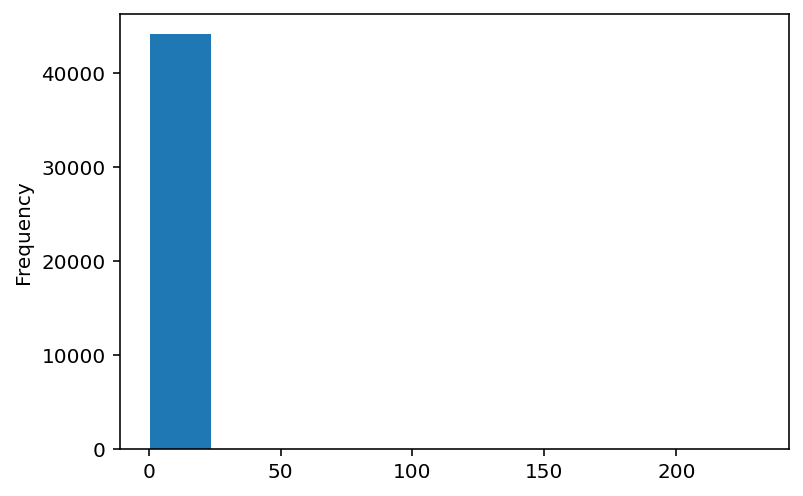

In [65]:
loci_df.MEAN_DEPTH.plot(kind="hist");

In [66]:
len(loci_df[loci_df.Fis == -9])

0

In [67]:
len(loci_df[loci_df.SUM_DEPTH <5000]),len(loci_df[loci_df.SUM_DEPTH >=200])

(44071, 44112)

In [68]:
len(loci_df[loci_df.MEAN_DEPTH > 25 ]),len(loci_df[loci_df.MEAN_DEPTH >= 2])

(12, 13092)

In [69]:
len(loci_df[loci_df.QUAL >= 20]) - len(loci_df[loci_df.QUAL >= 30])

4

In [70]:
len(loci_df[loci_df.QUAL >  20]), len(loci_df[loci_df.QUAL > 50]), len(loci_df[loci_df.QUAL > 100])

(44108, 44087, 43939)

In [71]:
 len(loci_df[loci_df.Fis <= -0.5]), len(loci_df[loci_df.MAF < 0.01])

(130, 2)

In [72]:
def filter_snps(df, imputed=False):
    if imputed:
        return df[(df.MAF >= 0.01) &  
                  (df.Fis > -0.5)]
    else:
        return df[(df.MEAN_DEPTH >= 2) & 
                  (df.MEAN_DEPTH < 25) & 
                  (df.QUAL >= 100) & 
                  (df.MAF >= 0.01) &
                  (df.Fis >= -0.5)]

In [73]:
loci_stage1 = filter_snps(loci_df)
loci_stage1.shape

(13003, 25)

In [74]:
with open(os.path.join(analysis_dir, "stage1_positions.txt"), "w") as o:
    for elem in loci_stage1.index:
        o.write("%s\n" % "\t".join(elem.split("-")))

In [75]:
!$vcftools --gzvcf $vcf_bad_remove_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--positions {os.path.join(analysis_dir, "stage1_positions.txt")} \
--out {os.path.join(analysis_dir, "good_snps")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/snps_indv_removed.recode.vcf.gz
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/good_snps
	--positions /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/stage1_positions.txt
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 403 out of 403 Individuals
Outputting VCF file...
After filtering, kept 13003 out of a possible 44112 Sites
Run Time = 11.00 seconds


In [76]:
snps = os.path.join(analysis_dir, "good_snps.recode.vcf")
snps_gz = snps + ".gz"
!$bgzip -c {snps} > {snps_gz}
!$tabix {snps_gz}

### Miss indv!

In [77]:
%%R
vcf <- read.vcfR("good_snps.recode.vcf", verbose = FALSE)

#get positions
chrom <- getCHROM(vcf)
pos <- getPOS(vcf)
pos_ID <- paste(chrom,pos,sep = ':')

In [78]:
%%R
#get DP 
dp <- extract.gt(vcf, element = 'DP')

In [79]:
%%R
## check out PL and pos_ID
print(length(pos_ID))
print(pos_ID[1:10])
dp[1:5,1:5]

[1] 13003
 [1] "CM042338.1:1496841"  "CM042338.1:6353755"  "CM042338.1:8177835" 
 [4] "CM042338.1:8530959"  "CM042338.1:8548932"  "CM042338.1:8655617" 
 [7] "CM042338.1:8698291"  "CM042338.1:10453589" "CM042338.1:10896687"
[10] "CM042338.1:10966361"
                   AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14
CM042338.1_1496841 "0"       "1"       "3"       "6"       "8"      
CM042338.1_6353755 "7"       "3"       "5"       "5"       "6"      
CM042338.1_8177835 "4"       "4"       "2"       "6"       "2"      
CM042338.1_8530959 "30"      "15"      "4"       "13"      "8"      
CM042338.1_8548932 "0"       "1"       "0"       "2"       "0"      


In [80]:
%%R
ID <- colnames(dp)
print(length(ID))
print(ID[1:10])

[1] 403
 [1] "AT2_BB_10" "AT2_BB_11" "AT2_BB_12" "AT2_BB_13" "AT2_BB_14" "AT2_BB_15"
 [7] "AT2_BB_16" "AT2_BB_17" "AT2_BB_1"  "AT2_BB_2" 


In [81]:
%%R
nloci <- nrow(dp)
#print(nloci)

miss_indv <- apply(dp,2, function(d) length(which(d == "0"))/nloci)
print(length(miss_indv))
print(summary(miss_indv))

[1] 403
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05868 0.14720 0.19565 0.20960 0.25413 0.78705 


In [82]:
%%R
for (perc in seq(.1,.9,by=.1)){
    print(paste0('number of individuals with greater than ',perc*100,'% missing data.....  ',
                 length(which(miss_indv >= perc))))
}

[1] "number of individuals with greater than 10% missing data.....  375"
[1] "number of individuals with greater than 20% missing data.....  191"
[1] "number of individuals with greater than 30% missing data.....  45"
[1] "number of individuals with greater than 40% missing data.....  13"
[1] "number of individuals with greater than 50% missing data.....  6"
[1] "number of individuals with greater than 60% missing data.....  4"
[1] "number of individuals with greater than 70% missing data.....  3"
[1] "number of individuals with greater than 80% missing data.....  0"
[1] "number of individuals with greater than 90% missing data.....  0"


In [84]:
%%R
miss50_indv_df <- data.frame(INDV=ID[which(miss_indv >= .50)])
miss50_indv_df
write.table(miss50_indv_df,'miss50_indv.txt',quote=F,row.names=F,col.names=T)

### use vcftools to remove individuals and loci based off above parameters

In [85]:
!$vcftools --gzvcf $snps_gz \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--remove {os.path.join(analysis_dir, "miss50_indv.txt")} \
--out {os.path.join(analysis_dir, "final_snps")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/good_snps.recode.vcf.gz
	--remove /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/miss50_indv.txt
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/final_snps
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
Excluding individuals in 'exclude' list
After filtering, kept 397 out of 403 Individuals
Outputting VCF file...
After filtering, kept 13003 out of a possible 13003 Sites
Run Time = 10.00 seconds


In [86]:
final_snps = os.path.join(analysis_dir, "final_snps.recode.vcf")
final_snps_gz = final_snps + ".gz"
!$bgzip -c {final_snps} > {final_snps_gz}
!$tabix {final_snps_gz}

# Make 012

In [87]:
f = os.path.join(analysis_dir, "final_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--012


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/final_snps.recode.vcf
	--012
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/final_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 397 out of 397 Individuals
Writing 012 matrix files ... Done.
After filtering, kept 13003 out of a possible 13003 Sites
Run Time = 2.00 seconds


# Get coverage per individual

In [88]:
f = os.path.join(analysis_dir, "final_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/final_snps.recode.vcf
	--depth
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/ATAV2/filtering/final_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 397 out of 397 Individuals
Outputting Mean Depth by Individual
After filtering, kept 13003 out of a possible 13003 Sites
Run Time = 1.00 seconds


In [89]:
depth_file = os.path.join(analysis_dir, "final_snps.recode.vcf.idepth")
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,AT2_BB_10,13003,5.14958
1,AT2_BB_11,13003,3.15827
2,AT2_BB_12,13003,2.74467
3,AT2_BB_13,13003,3.98416
4,AT2_BB_14,13003,5.50065


In [90]:
depth_df.MEAN_DEPTH.describe()

count    397.000000
mean       3.176034
std        1.033001
min        1.251250
25%        2.361990
50%        3.006540
75%        3.810350
max        7.006690
Name: MEAN_DEPTH, dtype: float64

# Remove unnecessary files

In [91]:
!rm snps*

In [92]:
!rm *vcf